In [1]:
from scipy import stats 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Epydemix import
import sys 
sys.path.append("../")
from epydemix.population import Population
from epydemix.epimodel import EpiModel, stochastic_simulation
from epydemix.plotting import plot_quantiles, plot_selected_quantiles, plot_posterior, plot_posterior_2d
from epydemix.calibration import calibration_top_perc, calibration_abc_smc

# Calibration

Import population data:

In [2]:
population = Population() 
population.load_population(population_name="Indonesia", path_to_data="../epydemix_data/")

Import epidemiological data:

In [3]:
df_I = pd.read_csv("./data/data_I.csv")
df_incidence = pd.read_csv("./data/data_incidence.csv")

Define model and priors:

In [4]:
# create model 
model = EpiModel(compartments=["S", "I", "R"])
model.add_parameters({"bet": 0.02, "mu": 0.2})
model.add_transition(source="S", target="I", rate_name="bet", agent="I")
model.add_transition(source="I", target="R", rate_name="mu")

# initial conditions
S=population.Nk - np.ones(len(population.Nk))
I=np.ones(len(population.Nk))
R=np.zeros(len(population.Nk))

# simulation dates
steps = "daily"
start_date=df_I.date.values[0]
end_date=df_I.date.values[-1]
start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
simulation_dates = pd.date_range(start=start_date, end=end_date, freq="d").tolist()
model.compute_contact_reductions(population, simulation_dates)

# parameters
parameters = {"Cs": model.Cs, 
              "Nk": population.Nk, 
              "S": S, 
              "I": I, 
              "R": R, 
              "epimodel": model, 
              "dt": np.diff(simulation_dates)[0] / timedelta(days=1),
              "population": population, 
              "simulation_dates": simulation_dates}

# priors
priors = {"bet": stats.uniform(0.015, 0.025), "mu": stats.uniform(0.15, 0.25)}

## Top % Calibration

In [ ]:
def post_processing_function(results, **parameters): 
    results.update({"data": results["I_total"]})
    return results

results = calibration_top_perc(simulation_function=stochastic_simulation, 
                               parameters=parameters,
                               priors=priors, 
                               data={"data": df_I["I"].values},
                               top_perc=0.05,
                               Nsim=1000,
                               post_processing_function=post_processing_function)

In [ ]:
plot_selected_quantiles(results, ylabel="I_total")

In [ ]:
plot_posterior(results, "bet", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

In [ ]:
plot_posterior_2d(results, "bet", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")

# Incidence example

In [ ]:
def post_processing_function(results, **parameters): 
    results.update({"data": np.concatenate(([0], (np.abs(np.diff(results["S_total"])))))})
    return results

results = calibration_top_perc(simulation_function=stochastic_simulation, 
                               parameters=parameters,
                               priors=priors, 
                               data={"data": df_incidence["incidence"].values},
                               top_perc=0.05,
                               Nsim=1000,
                               post_processing_function=post_processing_function)

In [ ]:
plot_selected_quantiles(results, ylabel="incidence")

In [ ]:
plot_posterior(results, "bet", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

In [ ]:
plot_posterior_2d(results, "bet", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")

## ABC-SMC

In [7]:
def post_processing_function(results, **parameters): 
    results.update({"data": np.concatenate(([0], (np.abs(np.diff(results["S_total"])))))})
    return results

hist = calibration_abc_smc(simulation_function=stochastic_simulation, 
                           priors=priors, 
                           parameters=parameters, 
                           data={"data": df_incidence["incidence"].values}, 
                           post_processing_function=post_processing_function, 
                           population_size=50)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=13, start_time=2024-06-04 13:02:22>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 2.80852450e+06.
ABC INFO: Accepted: 50 / 105 = 4.7619e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 2.19878930e+06.
ABC INFO: Accepted: 50 / 152 = 3.2895e-01, ESS: 4.5082e+01.
ABC INFO: t: 2, eps: 1.01492188e+06.
ABC INFO: Accepted: 50 / 129 = 3.8760e-01, ESS: 4.9161e+01.
ABC INFO: t: 3, eps: 7.01409808e+05.
ABC INFO: Accepted: 50 / 121 = 4.1322e-01, ESS: 4.6116e+01.
ABC INFO: t: 4, eps: 5.60396052e+05.
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated
ABC INFO: Accepted: 50 / 146

In [25]:
# format results 
from epydemix.calibration_results import CalibrationResults
from epydemix.utils import compute_quantiles
results = CalibrationResults()
results.set_calibration_strategy("abc_smc")
results.set_posterior_distribution(hist.get_distribution()[0])
results.set_selected_trajectories(np.array([d["data"] for d in hist.get_weighted_sum_stats()[1]]))
results.set_data({"data": df_incidence["incidence"].values})
results.set_priors(priors)
#results.set_calibration_params({"top_perc": top_perc, 
                                #"error_metric": , 
#                                "Nsim": Nsim})
selected_simulations_quantiles = compute_quantiles({"data": [d["data"] for d in hist.get_weighted_sum_stats()[1]]}, simulation_dates=parameters["simulation_dates"])
results.set_selected_quantiles(selected_simulations_quantiles)

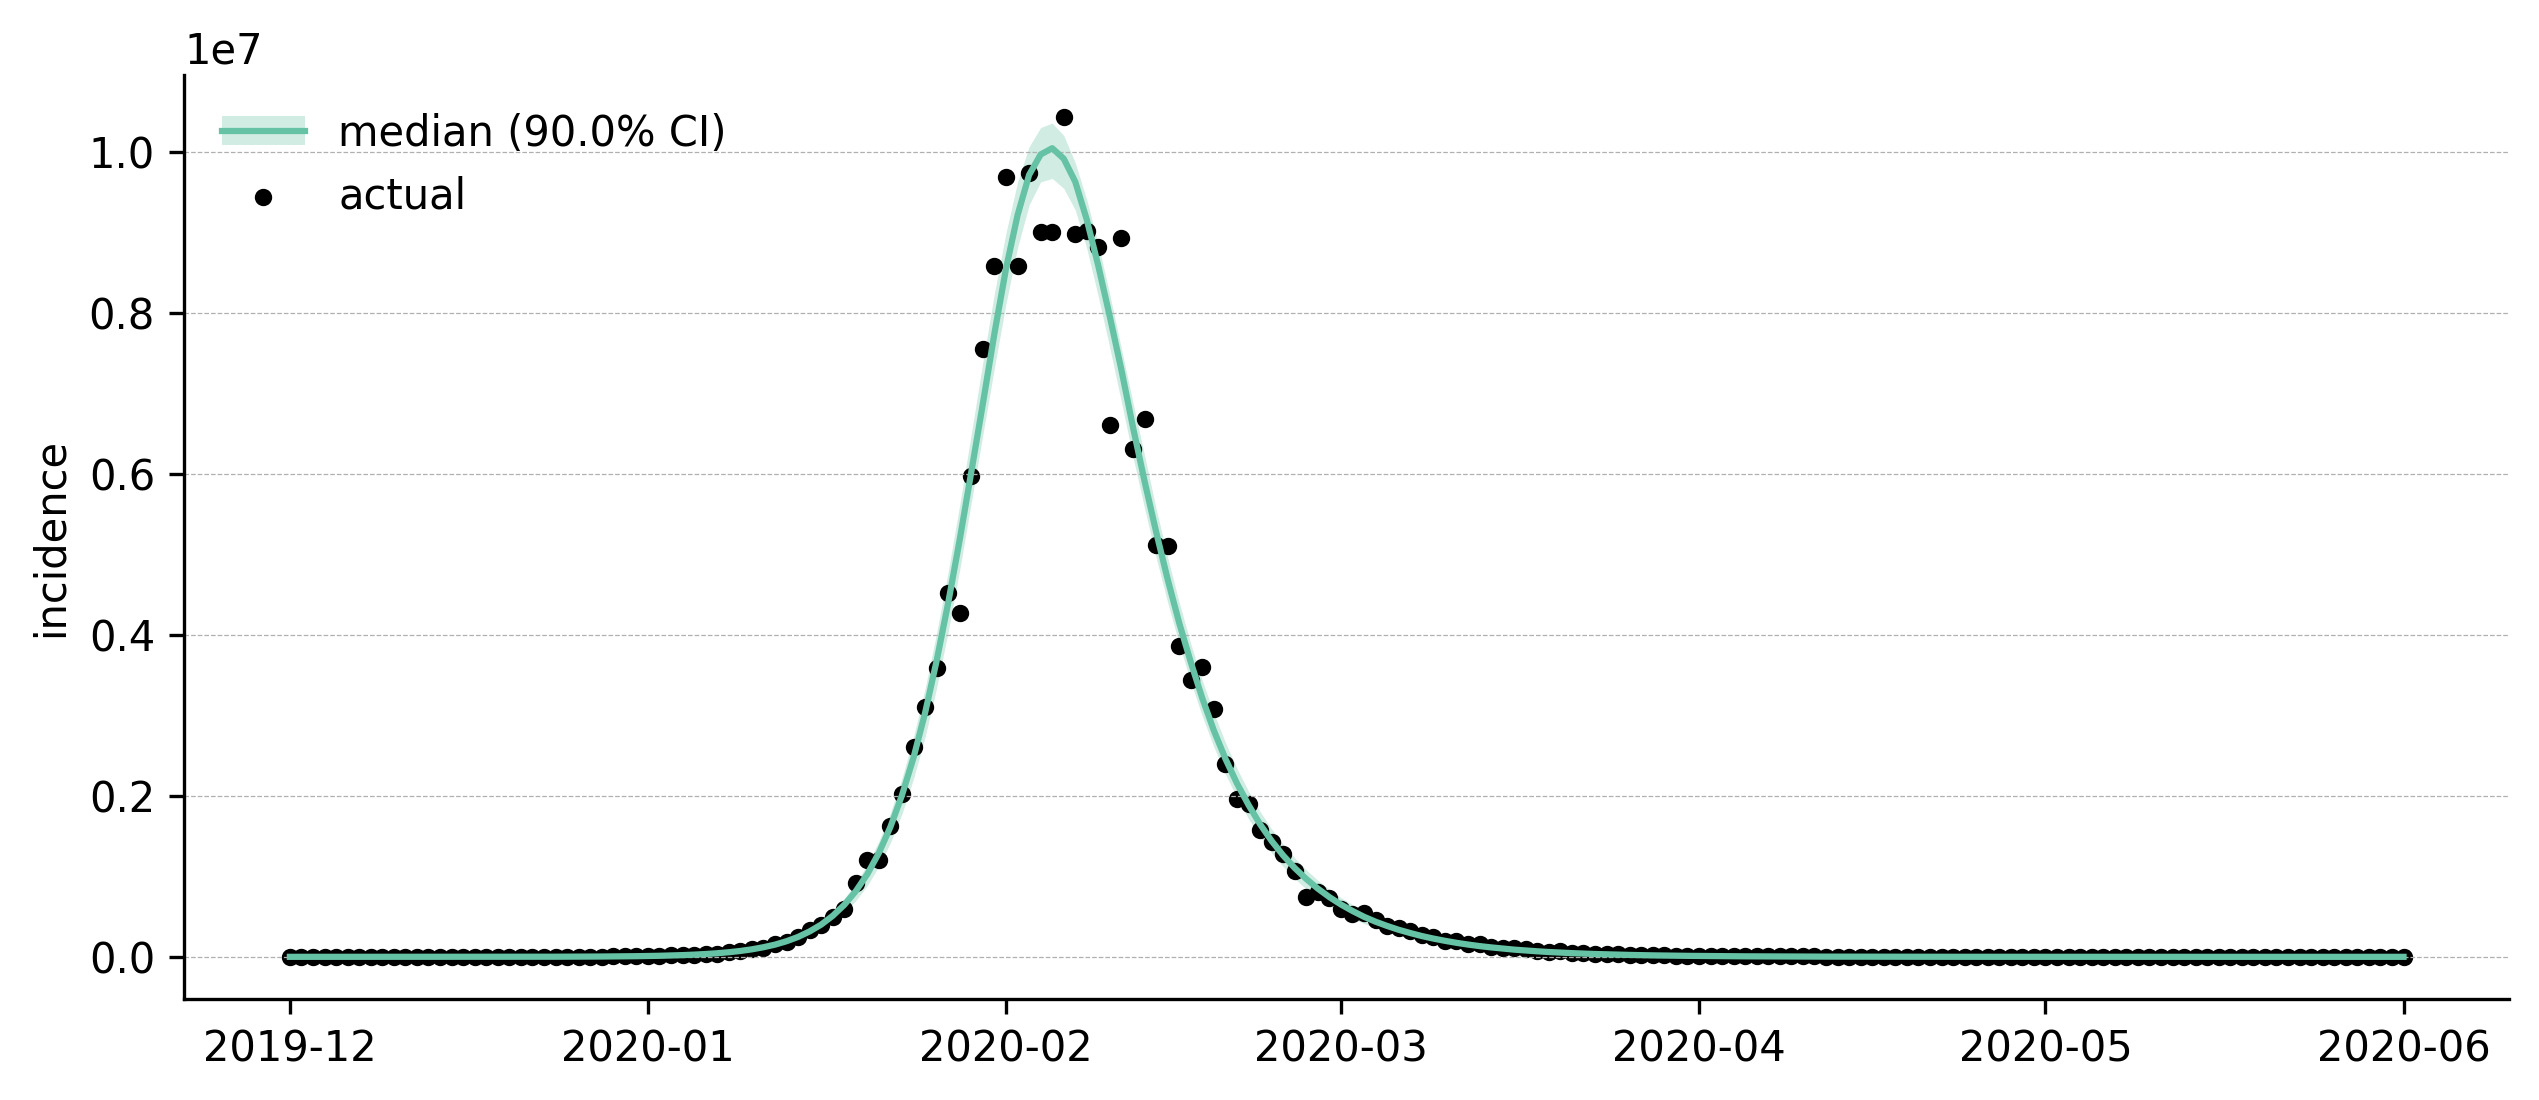

In [26]:
plot_selected_quantiles(results, ylabel="incidence")

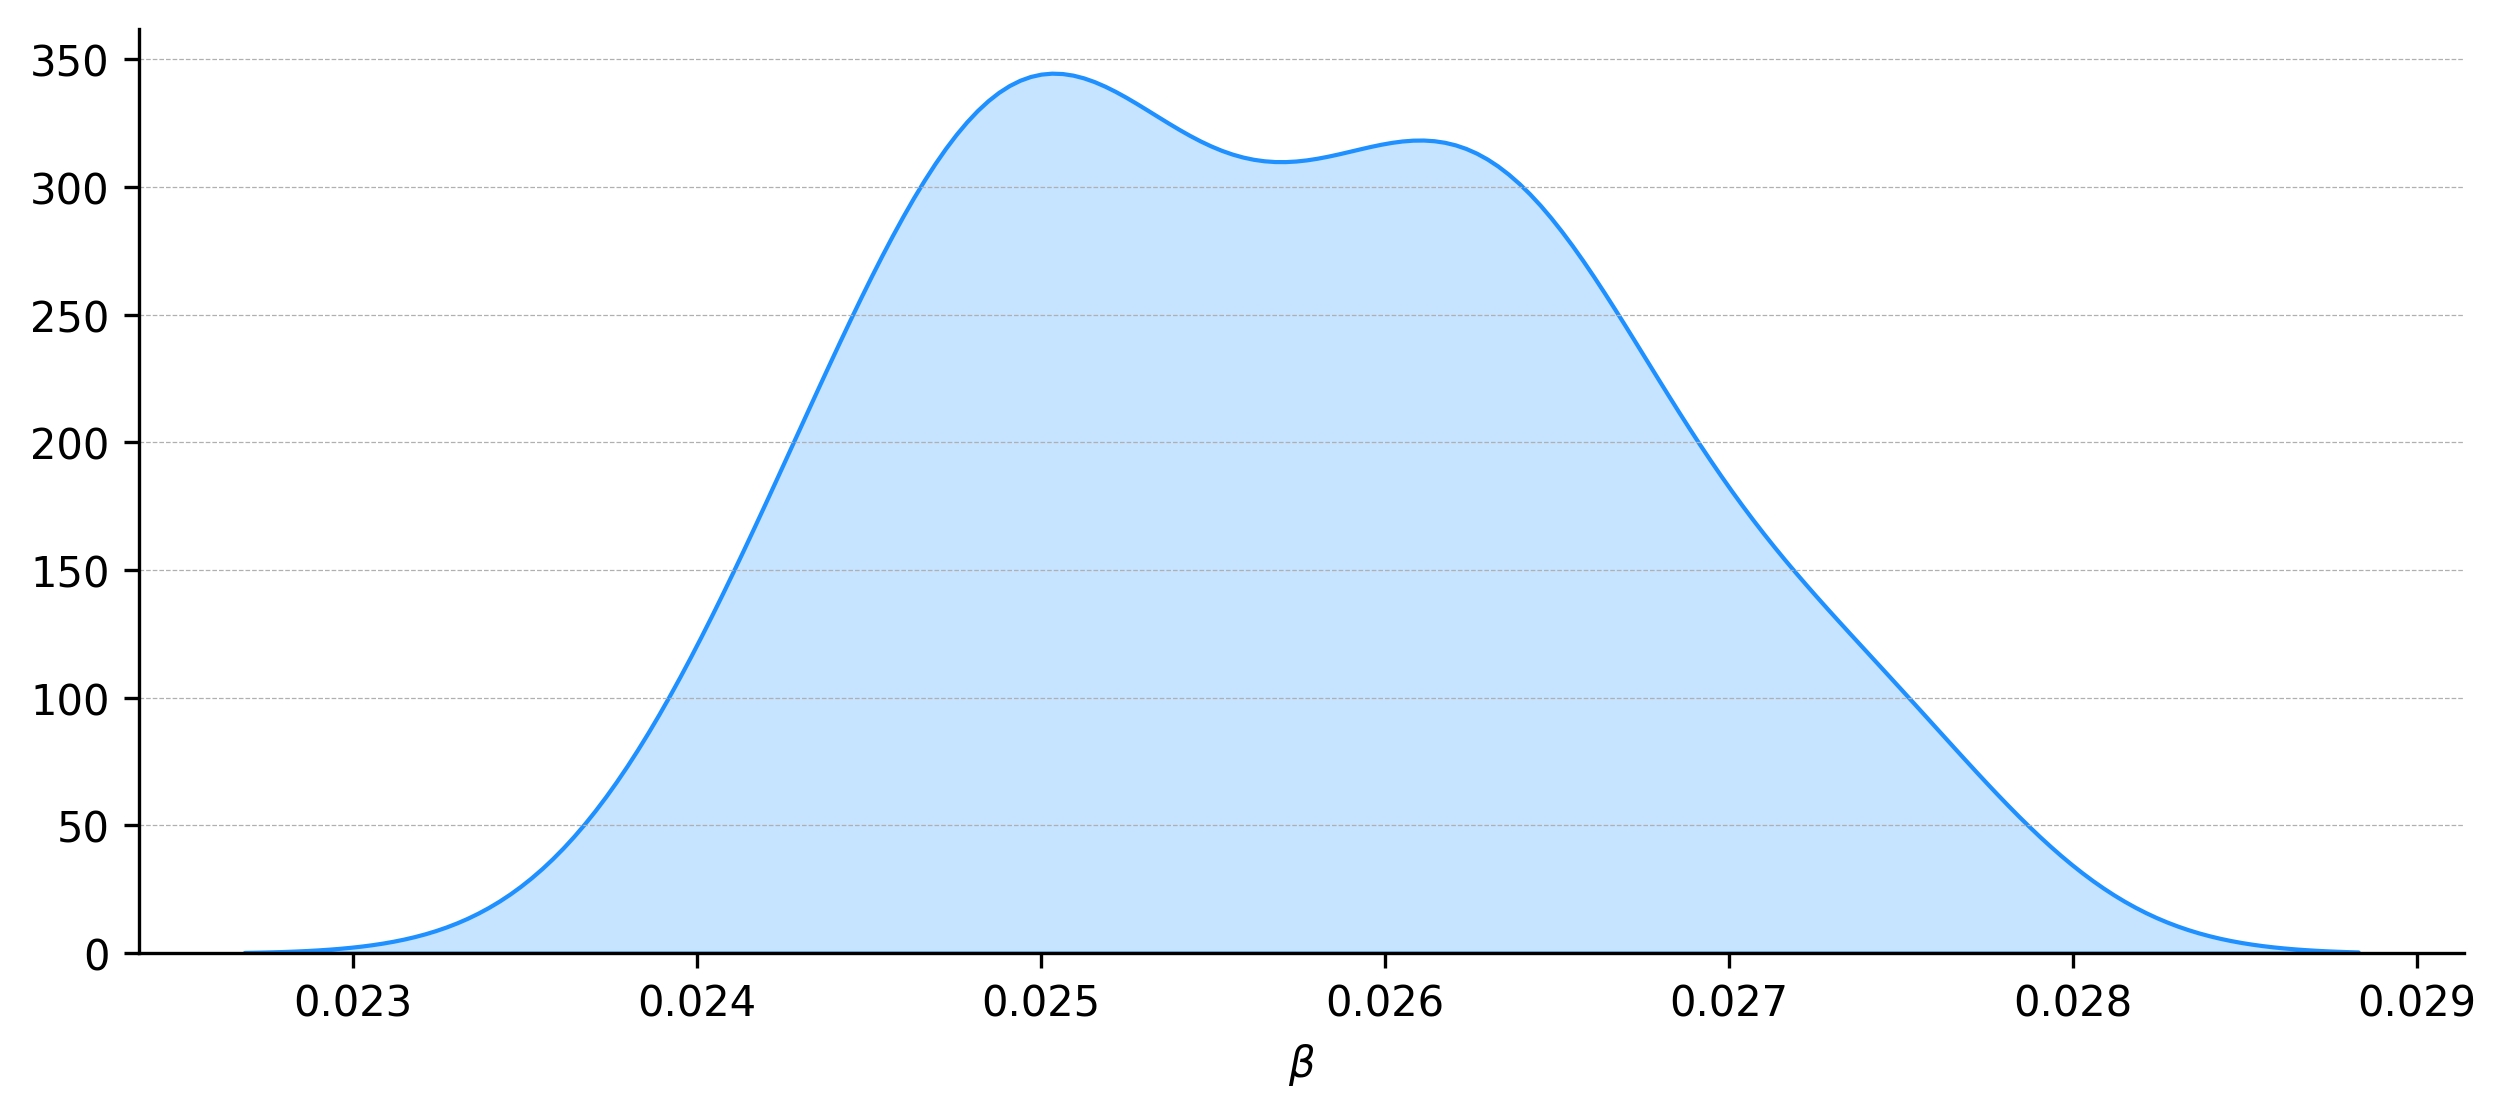

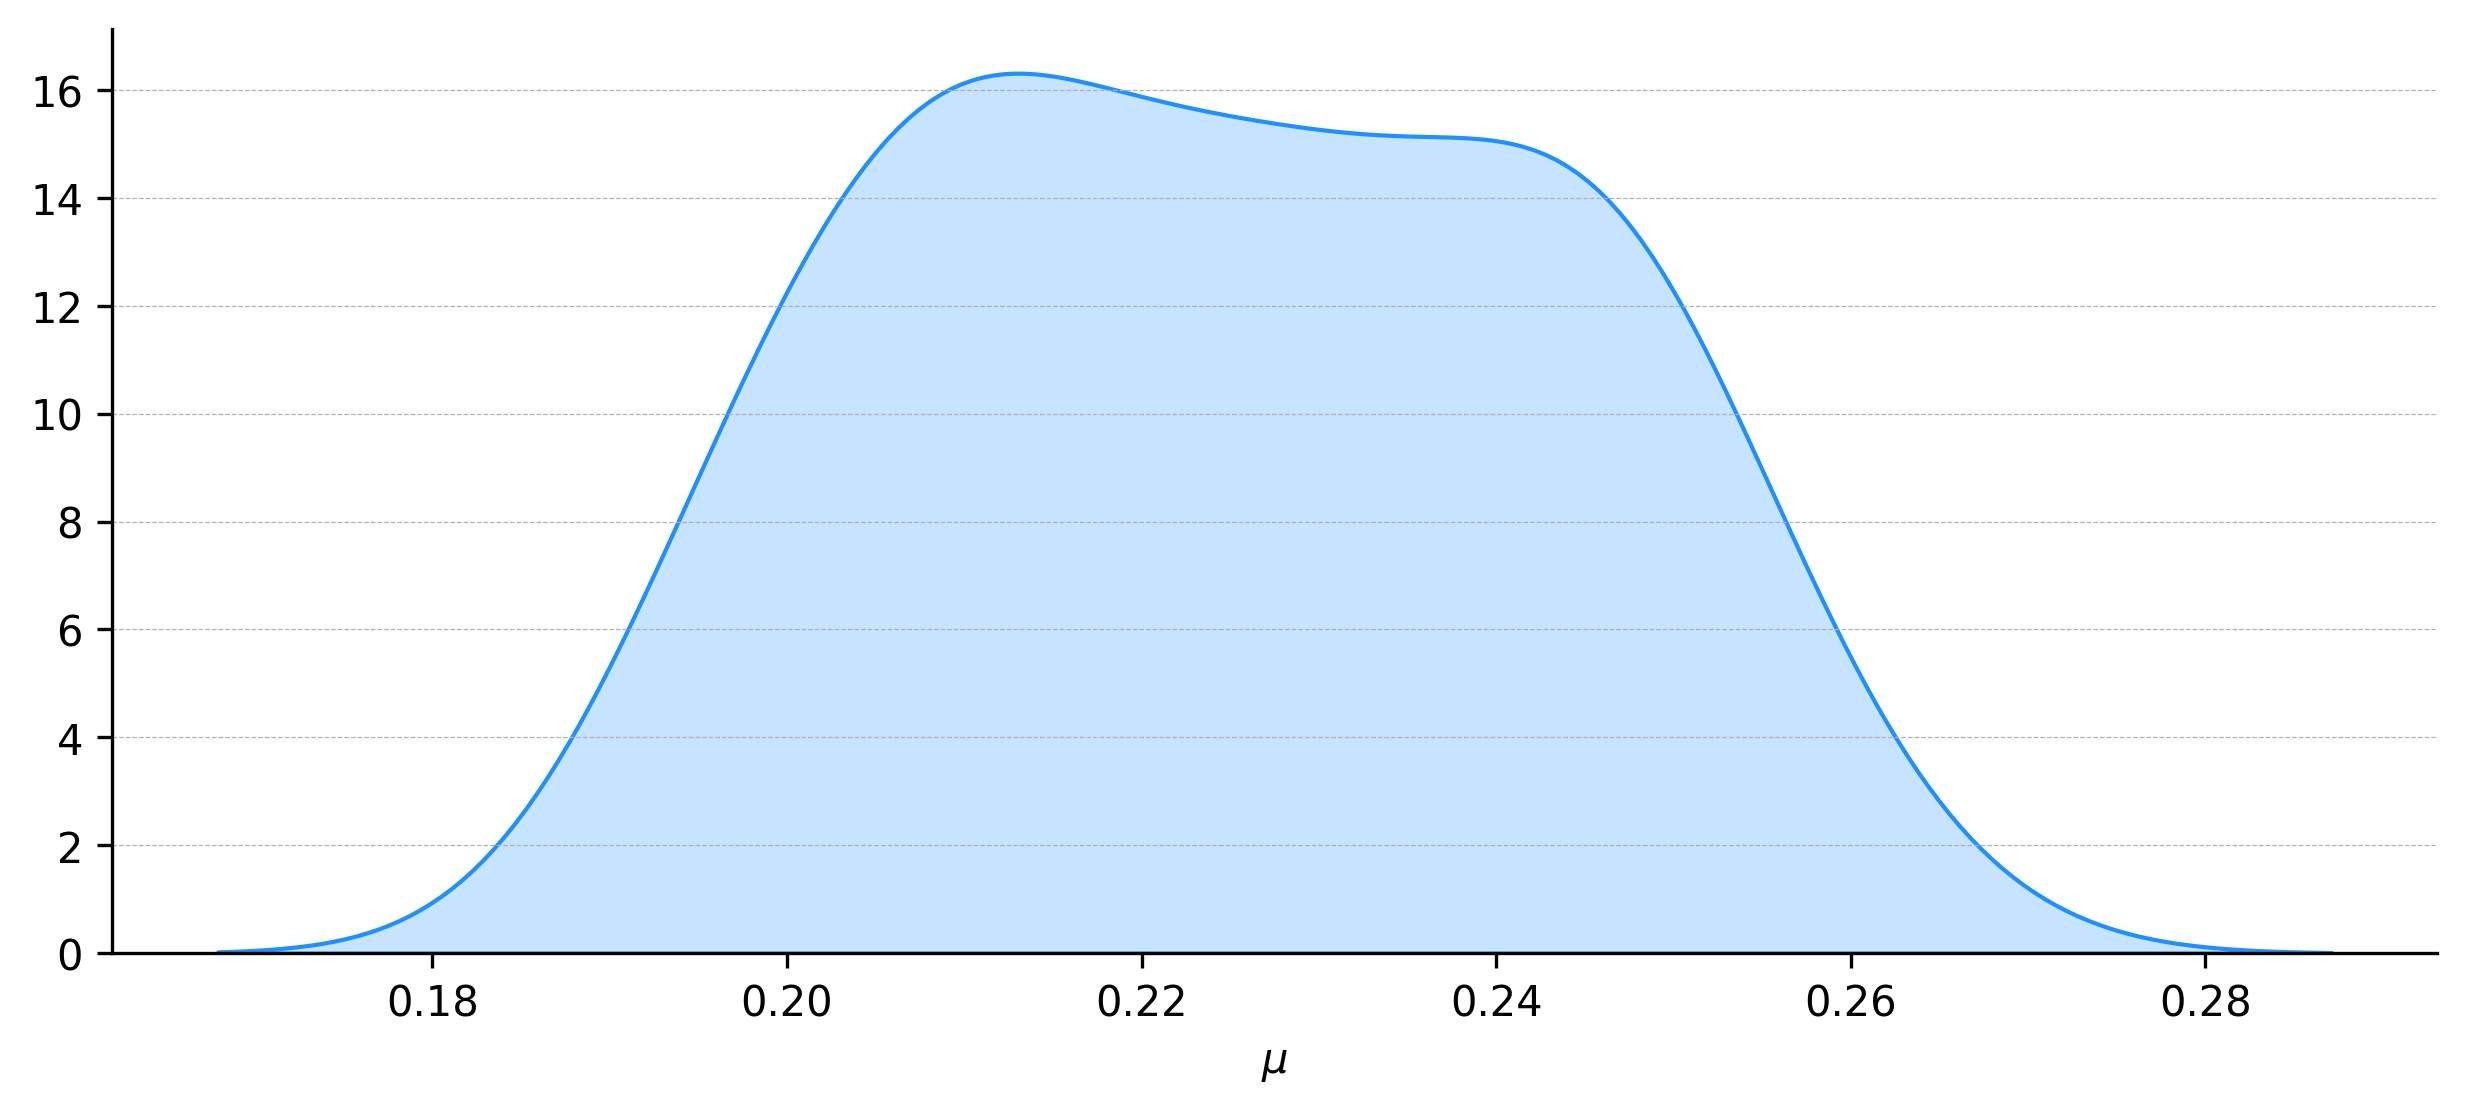

In [16]:
plot_posterior(results, "bet", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

../epydemix/plotting.py:217: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)


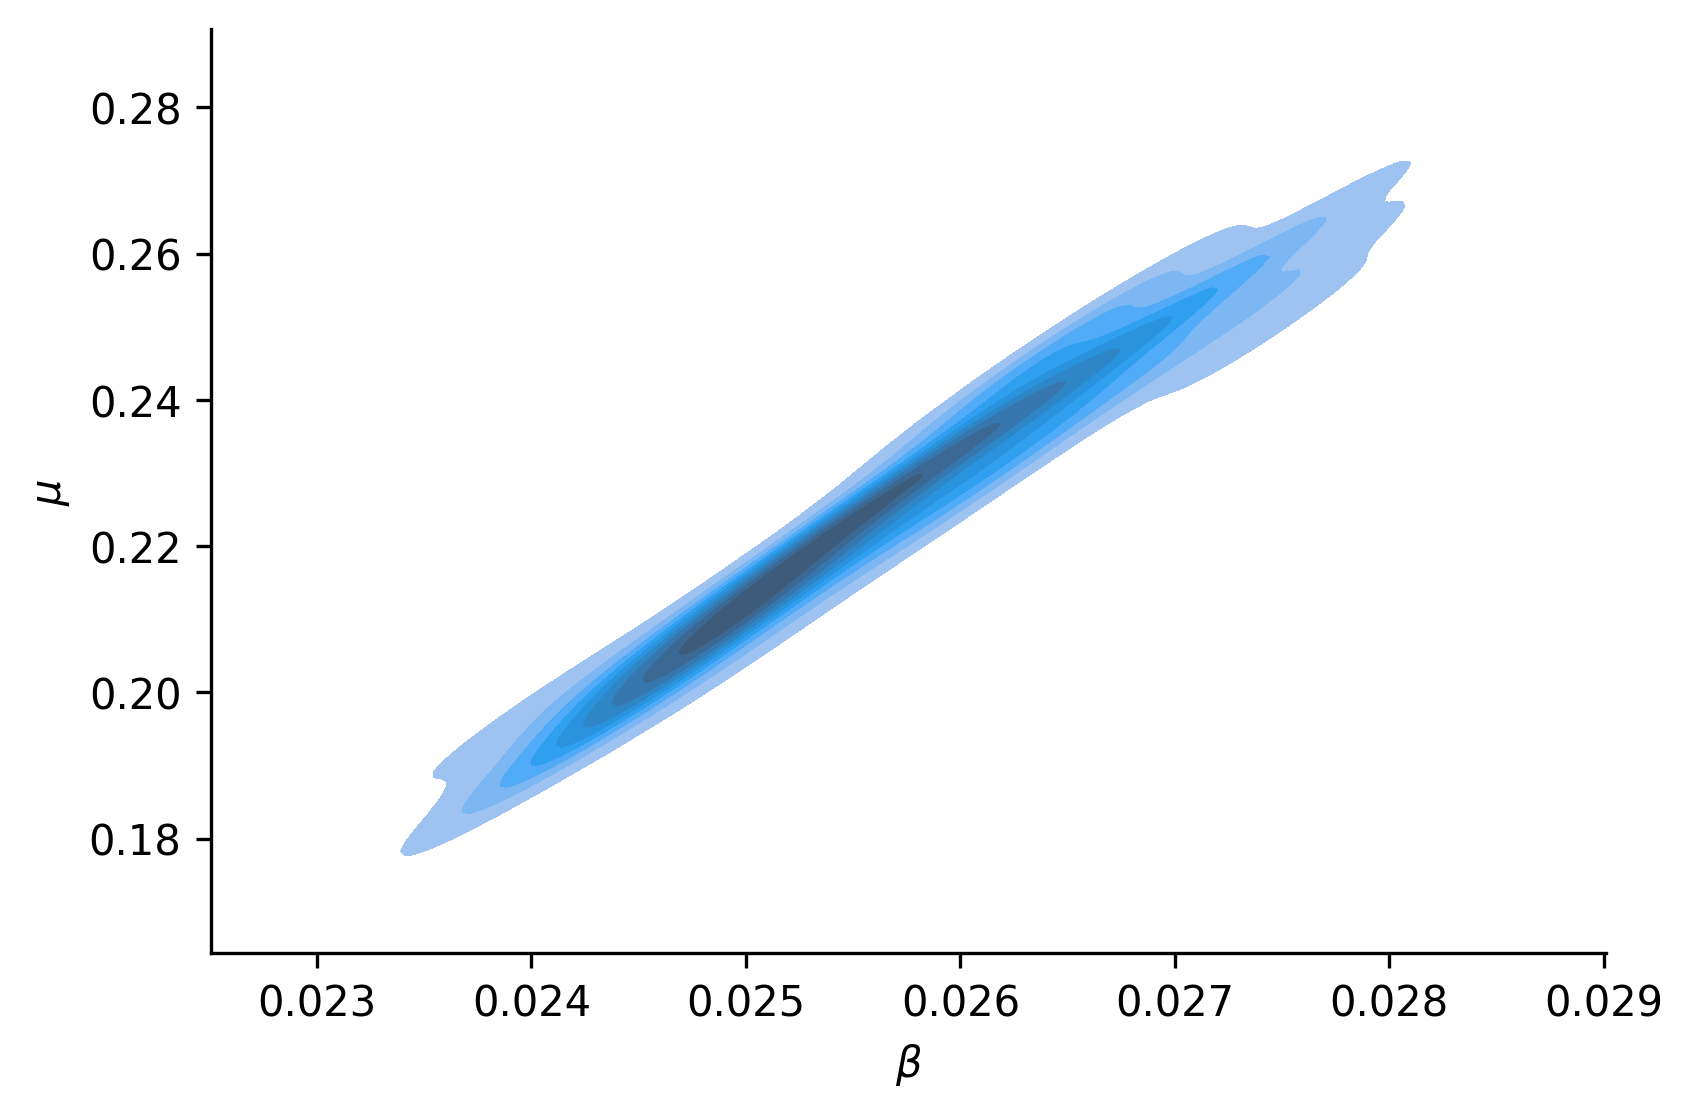

In [17]:
plot_posterior_2d(results, "bet", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")